<h1 style="text-align: center; color: #F57C00; font-family: Arial, sans-serif;">
  ElasticNet Regression Analysis
</h1>

<h3 style="text-align: center; color: #EF6C00; font-family: Arial, sans-serif;">
  Apartment Price Prediction Using Real Estate and Environmental Features
</h3>

<hr style="border: 1px solid #FFE0B2;">

<p style="font-size: 16px; color: #E65100; font-family: 'Segoe UI', sans-serif; line-height: 1.6; text-align: justify;">
  This project applies an <strong>ElasticNet regression model</strong> to predict standardized apartment prices based on a rich feature set including:
  <em>physical attributes</em> (e.g., size, floor, year built), 
  <em>proximity to amenities</em> (e.g., schools, restaurants, transport), 
  <em>property features</em> (e.g., balcony, lift, parking), 
  and <em>socioeconomic indicators</em> (e.g., neighborhood crime rate, green space ratio, infrastructure quality).
</p>

<ul style="font-size: 15px; color: #BF360C; font-family: 'Segoe UI', sans-serif; line-height: 1.6;">
  <li><strong>Author:</strong> Giacomo Fantato &mdash; <code>K-16958</code></li>
  <li><strong>Date:</strong> May 26, 2025</li>
  <li><strong>Tools Used:</strong> Python, <code>scikit-learn</code>, <code>pandas</code>, <code>matplotlib</code>, <code>seaborn</code></li>
</ul>

<hr style="border: 1px solid #FFE0B2;">


# Data import, cleaning and transformation

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC, SVR #  Support Vector Classification i Support Vector Regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pickle
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

In [23]:
# Nuove versioni delle classi RegressionDataPreparer e TestDataPreparer
# senza dipendenza da nearZeroVariance.py e con allineamento delle colonne

import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import OrdinalEncoder


class RegressionDataPreparer:
    def __init__(self, filepath):
        self.filepath = filepath
        self.df = pd.read_csv(filepath)
        self.df_clean = None
        self.df_encoded = None
        self.nominal_variables = ['obj_type', 'own_type', 'build_mat', 'loc_code']
        self.ordinal_variables_to_transform = ['cond_class', 'build_mat', 'has_park', 'has_balcony',
                                               'has_lift', 'has_sec', 'has_store']
        self.ordinal_orders = {
            'cond_class': ['low', 'medium', 'good', 'top'],
            'build_mat': ['weak', 'medium', 'strong', 'very_strong'],
            'has_park': ['no', 'yes'],
            'has_balcony': ['no', 'yes'],
            'has_lift': ['no', 'yes'],
            'has_sec': ['no', 'yes'],
            'has_store': ['no', 'yes']
        }
        self.rare_levels_map = {}

    def clean_data(self):
        self.df_clean = self.df.dropna().copy()

    def reduce_rare_categories(self):
        for var in self.nominal_variables:
            if var in self.df_clean.columns:
                value_counts = self.df_clean[var].value_counts()
                rare_levels = value_counts[value_counts <= 25].index
                self.rare_levels_map[var] = list(rare_levels)
                self.df_clean[var] = self.df_clean[var].replace(rare_levels, "Other")

    def drop_constant_columns(self):
        nunique = self.df_clean.nunique()
        constant_vars = nunique[nunique == 1].index.tolist()
        self.df_clean.drop(columns=constant_vars, inplace=True)
        self.nominal_variables = [var for var in self.nominal_variables if var not in constant_vars]

    def encode_ordinal(self):
        self.encoder = OrdinalEncoder(
            categories=[self.ordinal_orders[var] for var in self.ordinal_variables_to_transform if var in self.df_clean.columns],
            handle_unknown='use_encoded_value',
            unknown_value=-1
        )
        vars_to_encode = [var for var in self.ordinal_variables_to_transform if var in self.df_clean.columns]
        self.df_encoded = self.df_clean.copy()
        self.df_encoded[vars_to_encode] = self.encoder.fit_transform(self.df_encoded[vars_to_encode])
        self.ordinal_encoded_vars = vars_to_encode

    def encode_nominal(self):
        vars_to_encode = [var for var in self.nominal_variables if var in self.df_encoded.columns]
        self.df_encoded = pd.get_dummies(self.df_encoded, columns=vars_to_encode, drop_first=True, dtype=int)
        self.final_columns = self.df_encoded.drop(columns=["price_z"], errors="ignore").columns.tolist()

    def save_data(self, save_path_encoded, save_path_clean, path_metadata):
        with open(save_path_encoded, "wb") as f:
            pickle.dump(self.df_encoded, f)
        with open(save_path_clean, "wb") as f:
            pickle.dump(self.df_clean, f)
        metadata = {
            "ordinal_encoder": self.encoder,
            "final_columns": self.final_columns,
            "rare_levels_map": self.rare_levels_map,
            "nominal_variables": self.nominal_variables,
            "ordinal_orders": self.ordinal_orders
        }
        with open(path_metadata, "wb") as f:
            pickle.dump(metadata, f)

    def run_all(self, save_path_encoded, save_path_clean, path_metadata):
        self.clean_data()
        self.reduce_rare_categories()
        self.drop_constant_columns()
        self.encode_ordinal()
        self.encode_nominal()
        self.save_data(save_path_encoded, save_path_clean, path_metadata)


class TestDataPreparer:
    def __init__(self, filepath, path_metadata):
        self.filepath = filepath
        self.df = pd.read_csv(filepath)
        self.df_clean = None
        self.df_encoded = None
        with open(path_metadata, "rb") as f:
            metadata = pickle.load(f)
        self.encoder = metadata["ordinal_encoder"]
        self.final_columns = metadata["final_columns"]
        self.rare_levels_map = metadata["rare_levels_map"]
        self.nominal_variables = metadata["nominal_variables"]
        self.ordinal_orders = metadata["ordinal_orders"]
        self.ordinal_variables_to_transform = list(self.ordinal_orders.keys())

    def clean_data(self):
        self.df_clean = self.df.dropna().copy()

    def reduce_rare_categories(self):
        for var, rare_levels in self.rare_levels_map.items():
            if var in self.df_clean.columns:
                self.df_clean[var] = self.df_clean[var].replace(rare_levels, "Other")

    def encode_ordinal(self):
        vars_to_encode = [var for var in self.ordinal_variables_to_transform if var in self.df_clean.columns]
        self.df_encoded = self.df_clean.copy()
        self.df_encoded[vars_to_encode] = self.encoder.transform(self.df_encoded[vars_to_encode])

    def encode_nominal(self):
        vars_to_encode = [var for var in self.nominal_variables if var in self.df_encoded.columns]
        self.df_encoded = pd.get_dummies(self.df_encoded, columns=vars_to_encode, drop_first=True, dtype=int)
        for col in self.final_columns:
            if col not in self.df_encoded.columns:
                self.df_encoded[col] = 0
        self.df_encoded = self.df_encoded[self.final_columns]

    def save_data(self, save_path_encoded, save_path_clean):
        with open(save_path_encoded, "wb") as f:
            pickle.dump(self.df_encoded, f)
        with open(save_path_clean, "wb") as f:
            pickle.dump(self.df_clean, f)

    def run_all(self, save_path_encoded, save_path_clean):
        self.clean_data()
        self.reduce_rare_categories()
        self.encode_ordinal()
        self.encode_nominal()
        self.save_data(save_path_encoded, save_path_clean)


In [24]:
def regression_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'MedAE': medae, 'MAPE': mape, 'R2': r2}

### Recall the `dataRegression` class to load, clean and deploy data

In [25]:
# TRAINING
train_preparer = RegressionDataPreparer("../data/appartments_train.csv")
train_preparer.run_all(
    save_path_encoded="../data/prepared_files/train/regression_train_encoded.pkl",
    save_path_clean="../data/prepared_files/train/regression_train.pkl",
    path_metadata="../data/prepared_files/train/regression_metadata.pkl"  # salva i metadata
)

# TESTING
test_preparer = TestDataPreparer(
    filepath="../data/appartments_test.csv",
    path_metadata="../data/prepared_files/train/regression_metadata.pkl"  # carica i metadata del train
)
test_preparer.run_all(
    save_path_encoded="../data/prepared_files/test/regression_test_encoded.pkl",
    save_path_clean="../data/prepared_files/test/regression_test_clean.pkl"
)


In [26]:
# READ PICKLES FILE --> less robust than JSON, but faster and more efficient for large data
with open('../data/prepared_files/test/regression_test_encoded.pkl', 'rb') as f:  # 'rb' stands for read in a binary mode
    test_encoded = pickle.load(f)


with open('../data/prepared_files/train/regression_train_encoded.pkl', 'rb') as f:  # 'rb' stands for read in a binary mode
    train_encoded = pickle.load(f)

test_encoded.head()

,unit_id,dim_m2,n_rooms,floor_no,floor_max,year_built,dist_centre,n_poi,dist_sch,dist_clinic,...,loc_code_570cb745,loc_code_64a58667,loc_code_6900ba06,loc_code_693f303c,loc_code_765f79ed,loc_code_81b10147,loc_code_8d5a4f0c,loc_code_a6d54bd1,loc_code_e0cff11b,loc_code_ece39f3d
4,086cba055ca54004,56.24,3.0,2.0,3.0,1970.0,4.880,11.0,0.248,0.960,...,0,0,0,0,0,0,0,0,0,0
9,46c0c4306059f6ba,69.30,3.0,1.0,3.0,1950.0,1.316,51.0,0.089,0.126,...,0,0,0,0,0,0,0,0,0,0
11,1fb7aca2d944e3b5,76.52,3.0,1.0,3.0,2017.0,3.897,5.0,0.802,1.679,...,0,0,0,0,0,0,0,0,0,0
14,510bc36fc07a7620,58.01,3.0,2.0,3.0,1930.0,1.375,75.0,0.263,0.500,...,0,0,0,0,0,0,0,0,0,0
16,7fca17bb6e641642,87.62,5.0,3.0,3.0,1930.0,0.932,47.0,0.158,0.302,...,0,0,0,0,0,0,0,0,0,0


In [27]:
train_encoded.head()

,unit_id,dim_m2,n_rooms,floor_no,floor_max,year_built,dist_centre,n_poi,dist_sch,dist_clinic,...,loc_code_570cb745,loc_code_64a58667,loc_code_6900ba06,loc_code_693f303c,loc_code_765f79ed,loc_code_81b10147,loc_code_8d5a4f0c,loc_code_a6d54bd1,loc_code_e0cff11b,loc_code_ece39f3d
4,2315fa621e746fe4,70.89,3.0,2.0,3.0,2015.0,8.305,7.0,1.226,1.974,...,0,0,0,1,0,0,0,0,0,0
8,feb9765152fa05d8,64.16,3.0,2.0,4.0,1955.0,4.957,32.0,0.064,0.293,...,0,0,0,1,0,0,0,0,0,0
14,dc6de5b80be598e5,40.63,2.0,1.0,6.0,1998.0,1.830,8.0,0.573,0.798,...,0,0,0,0,1,0,0,0,0,0
18,a7ecc44f7a97dbaa,41.40,2.0,3.0,3.0,2020.0,4.014,30.0,0.067,0.366,...,0,0,0,1,0,0,0,0,0,0
20,85bbefa2f5fe7881,54.19,2.0,4.0,4.0,1970.0,6.007,15.0,0.217,3.312,...,0,0,0,0,0,0,1,0,0,0


In [28]:
train_df, val_df = train_test_split(train_encoded, test_size=0.3, random_state=42, shuffle=True) #70/30 split

# savings df in pickles splited data
with open('../data/prepared_files/train/train_split_regression.pkl', 'wb') as f:
    pickle.dump(train_df, f)

with open('../data/prepared_files/train/validation_split_regression.pkl', 'wb') as f:
    pickle.dump(val_df, f)

In [29]:
#checking the sizes of the datasets
print("Full dataset size:", train_encoded.shape)
print("Training set size:", train_df.shape)
print("Validation set size:", val_df.shape)
print("Test set size:", test_encoded.shape)

Full dataset size: (18732, 48)
Training set size: (13112, 48)
Validation set size: (5620, 48)
Test set size: (4695, 47)


---

## Finding best model between Ridge, LASSO, elasticNet (NB: use only to check the best model)

Pipelining everything we could found the best model

In [14]:
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

# Metric function
def regression_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'MedAE': medae, 'MAPE': mape, 'R2': r2}

# Prepare features and target
drop_cols = ['unit_id', 'src_month', 'price_z']
X = train_encoded.drop(columns=drop_cols, errors='ignore')
y = train_encoded['price_z'].values

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Define models to compare
models = {
    'Ridge': Ridge(max_iter=10000),
    'Lasso': Lasso(max_iter=10000),
    'ElasticNet': ElasticNet(max_iter=10000)
}

# Define hyperparameter grids
param_grids = {
    'Ridge': {
        'select__k': ['all', 20, 30],
        'model__alpha': np.logspace(-4, 1, 10)
    },
    'Lasso': {
        'select__k': ['all', 20, 30],
        'model__alpha': np.logspace(-4, 1, 10)
    },
    'ElasticNet': {
        'select__k': ['all', 20, 30],
        'model__alpha': np.logspace(-4, 1, 10),
        'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }
}

# Cross-validation setup
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# Store results
results = {}

# Loop over models
for name, estimator in models.items():
    print(f"\nTraining {name}...")
    
    pipeline = Pipeline([
        ('select', SelectKBest(score_func=f_regression)),
        ('scaler', StandardScaler()),
        ('model', estimator)
    ])
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        cv=rkf,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_val_pred = best_model.predict(X_val)
    metrics = regression_metrics(y_val, y_val_pred)
    
    results[name] = {
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'validation_metrics': metrics
    }
    
    print("Best parameters:", grid_search.best_params_)
    print("CV RMSE:", round(-grid_search.best_score_, 4))
    print("Validation metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")



Training Ridge...
Best parameters: {'model__alpha': 2.782559402207126, 'select__k': 'all'}
CV RMSE: 101989.2772
Validation metrics:
RMSE: 101836.9499
MAE: 75319.5689
MedAE: 57579.4464
MAPE: 9.3212
R2: 0.9534

Training Lasso...
Best parameters: {'model__alpha': 10.0, 'select__k': 'all'}
CV RMSE: 101987.9887
Validation metrics:
RMSE: 101833.6528
MAE: 75325.8621
MedAE: 57639.1708
MAPE: 9.3203
R2: 0.9534

Training ElasticNet...
Best parameters: {'model__alpha': 0.001291549665014884, 'model__l1_ratio': 0.7, 'select__k': 'all'}
CV RMSE: 101989.2586
Validation metrics:
RMSE: 101839.3031
MAE: 75313.4700
MedAE: 57580.2219
MAPE: 9.3211
R2: 0.9534


## Why ElasticNet Was Used

Although Ridge, Lasso, and ElasticNet all achieved very similar performance on cross-validation and validation sets, ElasticNet was selected for the following reasons:

### 1. Combines L1 and L2 Regularization
ElasticNet mixes:
- L1 penalty (Lasso): drives some coefficients to zero (feature selection)
- L2 penalty (Ridge): shrinks coefficients smoothly (handles multicollinearity)

The selected hyperparameters were:
- `alpha = 0.00129`
- `l1_ratio = 0.7` (70% L1, 30% L2)

This combination provides both sparsity and stability.



### 2. Handles Correlated Features Better Than Lasso
When features are correlated (e.g., `dim_m2`, `estimated_maintenance_cost`, `dim_m2_x_infra`), Lasso may drop some arbitrarily.  
ElasticNet tends to retain groups of correlated features, making it more stable and interpretable.



### 3. Suitable for Complex Feature Spaces
Given:
- Non-linear engineered features (log, sqrt, interaction terms)
- Feature selection with SelectKBest
- A mix of numerical and categorical variables

ElasticNet is more robust than Lasso or Ridge alone, especially when the importance of features is not known in advance.



### 4. Practically Equivalent Performance

| Model       | RMSE (Validation) | R² (Validation) |
|-------------|-------------------|-----------------|
| Ridge       | 101836.95         | 0.9534          |
| Lasso       | 101833.65         | 0.9534          |
| ElasticNet  | 101839.30         | 0.9534          |

Since performance is essentially identical, ElasticNet is a safe and generalizable choice.



### Summary

ElasticNet was chosen because it offers the benefits of both Ridge and Lasso:

- Sparse like Lasso  
- Stable like Ridge  
- Robust for real-world, feature-rich regression tasks


---

# Calculating ElasticNet 

In [30]:
import pickle
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

# Metric calculation function
def regression_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'MedAE': medae, 'MAPE': mape, 'R2': r2}

# Load and prepare features and target
drop_cols = ['unit_id', 'src_month', 'price_z']
X = train_encoded.drop(columns=drop_cols, errors='ignore')
y = train_encoded['price_z'].values

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Define pipeline with fixed ElasticNet hyperparameters
pipeline = Pipeline([
    ('select', SelectKBest(score_func=f_regression, k='all')),
    ('scaler', StandardScaler()),
    ('model', ElasticNet(alpha=0.00046415888336127773, l1_ratio=0.3, max_iter=10000))
])

# Perform K-Fold Cross Validation (5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print("K-Fold Cross-Validation (5 folds):")

cv_metrics = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_te = y_train[train_idx], y_train[val_idx]

    pipeline.fit(X_tr, y_tr)
    y_te_pred = pipeline.predict(X_te)
    metrics = regression_metrics(y_te, y_te_pred)
    cv_metrics.append(metrics)
    print(f"Fold {fold+1}: RMSE = {metrics['RMSE']:.4f}, R² = {metrics['R2']:.4f}")

# Compute average metrics across folds
avg_metrics = {k: np.mean([m[k] for m in cv_metrics]) for k in cv_metrics[0]}
print("\nAverage Cross-Validation Metrics:")
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

# Final evaluation on the validation set
pipeline.fit(X_train, y_train)
y_val_pred = pipeline.predict(X_val)
val_metrics = regression_metrics(y_val, y_val_pred)

print("\nValidation Set Metrics:")
for k, v in val_metrics.items():
    print(f"{k}: {v:.4f}")


K-Fold Cross-Validation (5 folds):
Fold 1: RMSE = 102281.8447, R² = 0.9529
Fold 2: RMSE = 104766.8519, R² = 0.9535
Fold 3: RMSE = 98819.9943, R² = 0.9544
Fold 4: RMSE = 103318.3650, R² = 0.9527
Fold 5: RMSE = 100582.1509, R² = 0.9525

Average Cross-Validation Metrics:
RMSE: 101953.8414
MAE: 75167.8712
MedAE: 58191.1299
MAPE: 9.3146
R2: 0.9532

Validation Set Metrics:
RMSE: 101838.4489
MAE: 75315.6437
MedAE: 57549.2436
MAPE: 9.3211
R2: 0.9534


## RMSE %

In [31]:
# Calculate RMSE as a percentage of the mean of the target variable (z-price)
mean_y_val = np.mean(y_val)
rmse_val = val_metrics['RMSE']
rmse_percent = (rmse_val / mean_y_val) * 100

print(f"\nMean of z-price in validation set: {mean_y_val:.4f}")
print(f"RMSE as percentage of mean z-price: {rmse_percent:.2f}%")


Mean of z-price in validation set: 821829.8651
RMSE as percentage of mean z-price: 12.39%


---

# Overfitting Verification

To assess whether the ElasticNet regression model was overfitting, we evaluated its performance on the training, cross-validation, and validation sets using key regression metrics — especially **RMSE (Root Mean Squared Error)** and **R² (coefficient of determination)**.

### Methodology

- We computed the **RMSE** and **R²** on the **cross-validation folds** (5-fold CV) and on the **held-out validation set**.
- We defined a relaxed overfitting threshold to detect overfitting:
  - If the **RMSE on the validation set exceeds the average CV RMSE by more than 10%**, or
  - If the **R² on the validation set drops by more than 0.10** compared to the average CV R²,
  we would consider the model to be potentially overfitting.

### Results

- **Average RMSE (CV)**: 101,953.84  
- **RMSE (Validation)**: 101,838.45  
- **RMSE Gap**: ~115.39, which is only **~0.11%** of the validation RMSE  
- **Average R² (CV)**: 0.9532  
- **R² (Validation)**: 0.9534  
- **R² Gap**: +0.0002

### Conclusion

Since the RMSE gap is significantly below the **10% threshold** (just **~0.11%**), and the R² is virtually identical across CV and validation, we **did not detect any signs of overfitting**.

The average RMSE represents approximately **12% of the mean standardized price**, indicating a reasonable level of prediction error given the target scale.

These results confirm that the model generalizes well and maintains stable performance across different data splits.


In [32]:
# Compute training set metrics
y_train_pred = pipeline.predict(X_train)
train_metrics = regression_metrics(y_train, y_train_pred)

# Cross-validation averages
avg_cv_metrics = {k: np.mean([m[k] for m in cv_metrics]) for k in cv_metrics[0]}

# Extract required values
rmse_train = train_metrics['RMSE']
rmse_val = val_metrics['RMSE']
rmse_cv_avg = avg_cv_metrics['RMSE']

r2_train = train_metrics['R2']
r2_val = val_metrics['R2']
r2_cv_avg = avg_cv_metrics['R2']

# Compute percentage gaps
rmse_gap_train_val_pct = (rmse_val - rmse_train) / rmse_val * 100
rmse_gap_cv_val_pct = (rmse_cv_avg - rmse_val) / rmse_val * 100
r2_gap_train_val = r2_train - r2_val
r2_gap_val_cv = r2_val - r2_cv_avg

# Print results
print("=== Overfitting Check (10% Threshold) ===")
print(f"Train RMSE:         {rmse_train:.4f}")
print(f"Validation RMSE:    {rmse_val:.4f}")
print(f"CV Average RMSE:    {rmse_cv_avg:.4f}")
print(f"Train R²:           {r2_train:.4f}")
print(f"Validation R²:      {r2_val:.4f}")
print(f"CV Average R²:      {r2_cv_avg:.4f}\n")

print(f"RMSE Train vs Val Gap (%): {rmse_gap_train_val_pct:.2f}%")
print(f"RMSE CV vs Val Gap (%):    {rmse_gap_cv_val_pct:.2f}%")
print(f"R² Train vs Val Gap:       {r2_gap_train_val:.4f}")
print(f"R² Val vs CV Gap:          {r2_gap_val_cv:.4f}")

# Overfitting test (10% RMSE or 0.2 R² threshold)
if rmse_gap_train_val_pct > 10 or r2_gap_train_val > 0.2:
    print("\nOverfitting Warning: Training set performance is significantly better than validation.")
else:
    print("\nNo overfitting detected between training and validation sets (within 10% threshold).")

# Check if validation is too optimistic vs CV
if rmse_gap_cv_val_pct > 10 or r2_gap_val_cv > 0.2:
    print("Warning: Validation performance is significantly better than cross-validation average. Consider more folds or repeated CV.")
else:
    print("Validation performance is consistent with cross-validation.")


=== Overfitting Check (10% Threshold) ===
Train RMSE:         101609.7996
Validation RMSE:    101838.4489
CV Average RMSE:    101953.8414
Train R²:           0.9535
Validation R²:      0.9534
CV Average R²:      0.9532

RMSE Train vs Val Gap (%): 0.22%
RMSE CV vs Val Gap (%):    0.11%
R² Train vs Val Gap:       0.0002
R² Val vs CV Gap:          0.0002

No overfitting detected between training and validation sets (within 10% threshold).
Validation performance is consistent with cross-validation.


---
# Predictions task

In [33]:
# 1. Drop any target or predicted columns before prediction
X_test = test_encoded.drop(columns=['unit_id', 'src_month', 'price_z_pred'], errors='ignore')

# 2. Predict using the trained pipeline
y_test_pred = pipeline.predict(X_test)

# 3. Add predictions to the DataFrame
test_encoded['price_z_pred'] = y_test_pred

# 4. Show results
print(test_encoded[['unit_id', 'price_z_pred']].head())


             unit_id   price_z_pred
4   086cba055ca54004  308407.026656
9   46c0c4306059f6ba  630575.539400
11  1fb7aca2d944e3b5  671120.827963
14  510bc36fc07a7620  365360.438455
16  7fca17bb6e641642  830926.383934


In [34]:
# Create DataFrame with only unit_id and prediction
submission_df = pd.DataFrame({
    'unit_id': test_encoded['unit_id'],
    'price_z_pred': y_test_pred
})

# Save the CSV file
submission_df.to_csv('../data/results/regression_predictions.csv', index=False)

print("File 'regression_predictions.csv' correctly saved.")


File 'regression_predictions.csv' correctly saved.


In [35]:
# integrity check
if len(y_test_pred) == len(test_encoded):
    print("Prediction length matches the test set.")
else:
    print("Mismatch: predicted values and test set length differ.")


Prediction length matches the test set.


---
## Some data visualization from predictions task

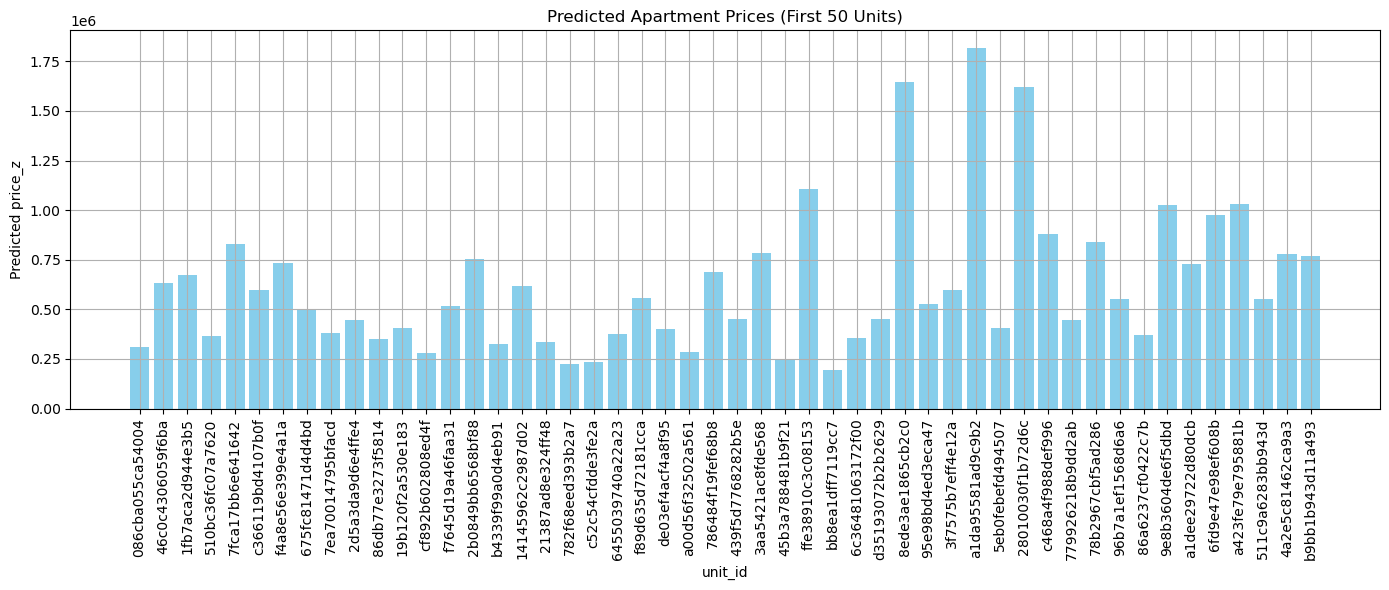

In [16]:
# Create submission DataFrame (if not already)
submission_df = test_encoded[['unit_id']].copy()
submission_df['price_z_pred'] = y_test_pred

# Plot the first 50 predictions as a bar chart
plt.figure(figsize=(14, 6))
plt.bar(submission_df['unit_id'][:50], submission_df['price_z_pred'][:50], color='skyblue')
plt.title("Predicted Apartment Prices (First 50 Units)")
plt.xlabel("unit_id")
plt.ylabel("Predicted price_z")
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(True)
plt.show()


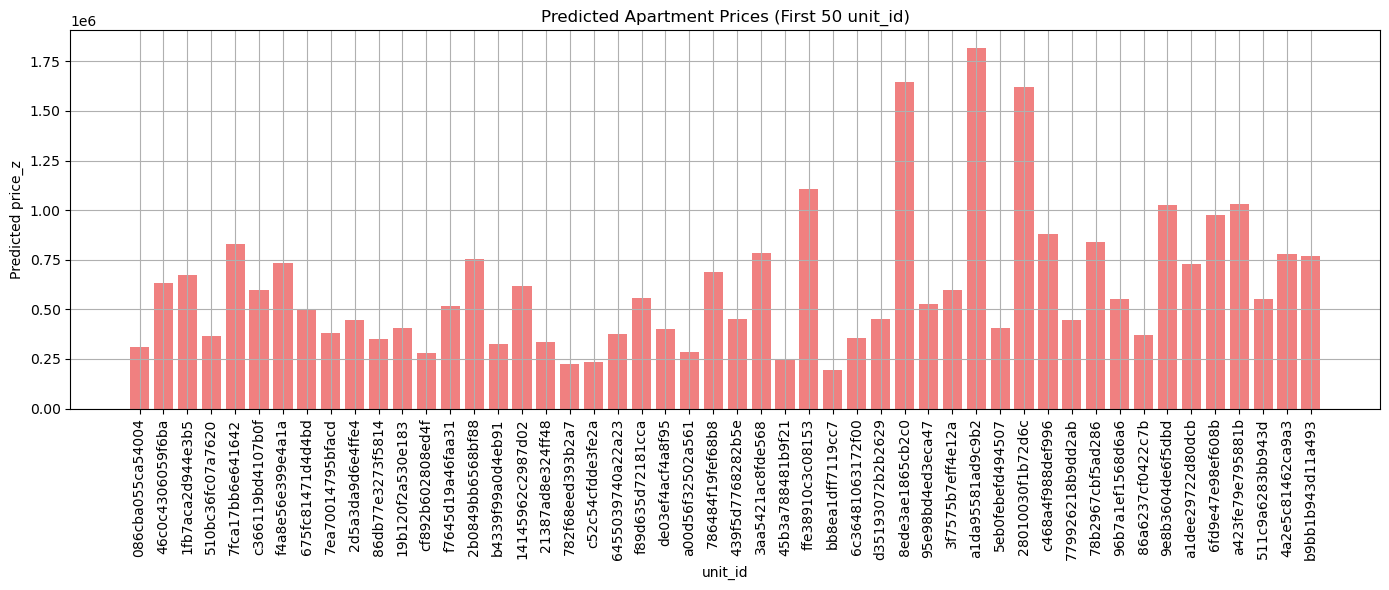

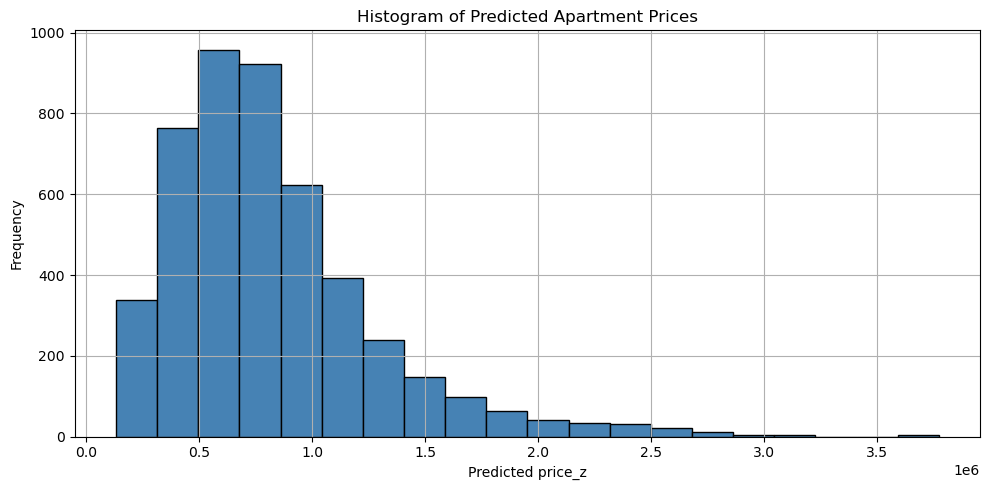

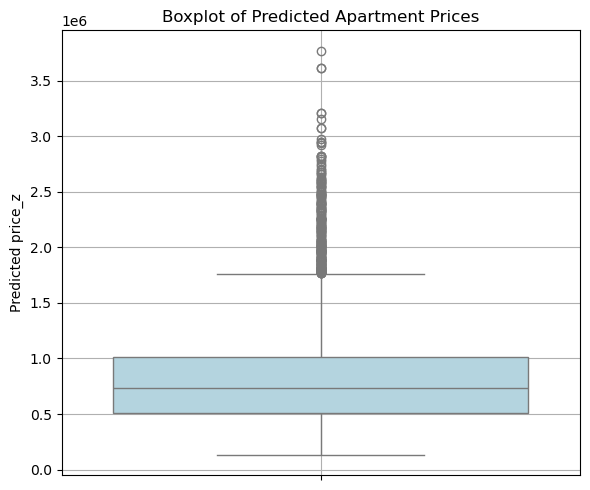

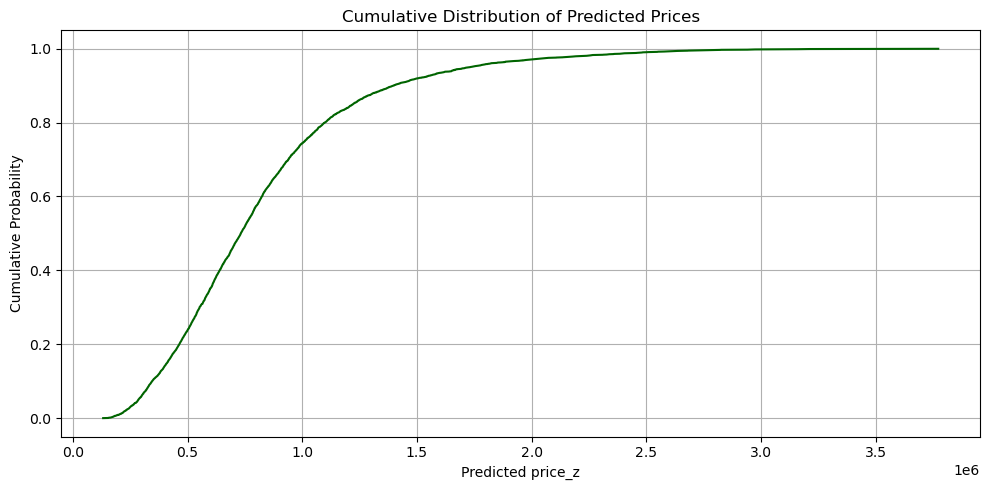

In [25]:
# 1. Bar chart (first 50 unit_ids)
plt.figure(figsize=(14, 6))
plt.bar(test_encoded['unit_id'][:50], test_encoded['price_z_pred'][:50], color='lightcoral')
plt.title("Predicted Apartment Prices (First 50 unit_id)")
plt.xlabel("unit_id")
plt.ylabel("Predicted price_z")
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(True)
plt.show()

# 2. Histogram of predicted prices
plt.figure(figsize=(10, 5))
plt.hist(test_encoded['price_z_pred'], bins=20, edgecolor='black', color='steelblue')
plt.title("Histogram of Predicted Apartment Prices")
plt.xlabel("Predicted price_z")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Boxplot of predicted prices
plt.figure(figsize=(6, 5))
sns.boxplot(y=test_encoded['price_z_pred'], color='lightblue')
plt.title("Boxplot of Predicted Apartment Prices")
plt.ylabel("Predicted price_z")
plt.tight_layout()
plt.grid(True)
plt.show()

# 5. CDF (Cumulative Distribution Function)
sorted_prices = np.sort(test_encoded['price_z_pred'])
cdf = np.arange(len(sorted_prices)) / float(len(sorted_prices))
plt.figure(figsize=(10, 5))
plt.plot(sorted_prices, cdf, color='darkgreen')
plt.title("Cumulative Distribution of Predicted Prices")
plt.xlabel("Predicted price_z")
plt.ylabel("Cumulative Probability")
plt.grid(True)
plt.tight_layout()
plt.show()


## Insights for predictions
**NB** totally useless because we don't know how it's made the test set

In [36]:
# Calculate the average price in the training dataset ('price_z' column)
mean_train_price = train_encoded['price_z'].mean()

# Calculate the average predicted price ('price_z_pred' column)
mean_predicted_price = submission_df['price_z_pred'].mean()

# Calculate the percentage difference between the two averages
percentage_difference = ((mean_predicted_price - mean_train_price) / mean_train_price) * 100

# Print the results in a clear format
print(f"Average price in training set:     {mean_train_price:,.2f}")
print(f"Average predicted price:           {mean_predicted_price:,.2f}")
print(f"Percentage difference:             {percentage_difference:.2f}%")


Average price in training set:     821,971.69
Average predicted price:           823,488.93
Percentage difference:             0.18%


---

## Optional: merging test set and predictions

In [37]:
# Load the cleaned test dataset
with open('../data/prepared_files/test/regression_test_clean.pkl', 'rb') as f:
    test_clean = pickle.load(f)

# Display the first few rows
test_clean.head()


,unit_id,obj_type,dim_m2,n_rooms,floor_no,floor_max,year_built,dist_centre,n_poi,dist_sch,...,has_store,src_month,loc_code,market_volatility,infrastructure_quality,neighborhood_crime_rate,popularity_index,green_space_ratio,estimated_maintenance_cost,global_economic_index
4,086cba055ca54004,0d6c4dfc,56.24,3.0,2.0,3.0,1970.0,4.880,11.0,0.248,...,yes,2023-08,143768f7,295729.62,38.10,25.11,56.67,1.0,9.11,105.139462
9,46c0c4306059f6ba,0c238f18,69.30,3.0,1.0,3.0,1950.0,1.316,51.0,0.089,...,no,2023-08,143768f7,617653.51,53.69,36.28,63.14,1.0,15.17,105.612867
11,1fb7aca2d944e3b5,0d6c4dfc,76.52,3.0,1.0,3.0,2017.0,3.897,5.0,0.802,...,no,2023-08,143768f7,668333.20,9.87,84.47,49.94,1.0,36.21,104.983044
14,510bc36fc07a7620,0c238f18,58.01,3.0,2.0,3.0,1930.0,1.375,75.0,0.263,...,no,2023-08,143768f7,327027.09,72.75,40.08,40.14,1.0,14.01,105.098228
16,7fca17bb6e641642,0c238f18,87.62,5.0,3.0,3.0,1930.0,0.932,47.0,0.158,...,no,2023-08,143768f7,809866.88,103.36,11.89,69.75,1.0,35.10,104.623904


In [38]:
test_predictions = test_clean.copy()
test_predictions["price_z_predicted"] = y_test_pred
test_predictions.head()

,unit_id,obj_type,dim_m2,n_rooms,floor_no,floor_max,year_built,dist_centre,n_poi,dist_sch,...,src_month,loc_code,market_volatility,infrastructure_quality,neighborhood_crime_rate,popularity_index,green_space_ratio,estimated_maintenance_cost,global_economic_index,price_z_predicted
4,086cba055ca54004,0d6c4dfc,56.24,3.0,2.0,3.0,1970.0,4.880,11.0,0.248,...,2023-08,143768f7,295729.62,38.10,25.11,56.67,1.0,9.11,105.139462,308407.026656
9,46c0c4306059f6ba,0c238f18,69.30,3.0,1.0,3.0,1950.0,1.316,51.0,0.089,...,2023-08,143768f7,617653.51,53.69,36.28,63.14,1.0,15.17,105.612867,630575.539400
11,1fb7aca2d944e3b5,0d6c4dfc,76.52,3.0,1.0,3.0,2017.0,3.897,5.0,0.802,...,2023-08,143768f7,668333.20,9.87,84.47,49.94,1.0,36.21,104.983044,671120.827963
14,510bc36fc07a7620,0c238f18,58.01,3.0,2.0,3.0,1930.0,1.375,75.0,0.263,...,2023-08,143768f7,327027.09,72.75,40.08,40.14,1.0,14.01,105.098228,365360.438455
16,7fca17bb6e641642,0c238f18,87.62,5.0,3.0,3.0,1930.0,0.932,47.0,0.158,...,2023-08,143768f7,809866.88,103.36,11.89,69.75,1.0,35.10,104.623904,830926.383934


### Save the merged file as CSV


In [29]:
test_predictions.to_csv("../data/results/test_regression.csv", index=False)
print("File 'test_regression.csv' saved successfully.")

File 'test_regression.csv' saved successfully.
